# **Using tf.data**

In [1]:
# Import packge
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers
import os

# 1.download data dog and cat in github

[data cats and dogs](https://github.com/thanhhoai2k4/data_cats_dogs)
 from github.

In [2]:
! git clone https://github.com/thanhhoai2k4/data_cats_dogs

Cloning into 'data_cats_dogs'...
remote: Enumerating objects: 24997, done.
remote: Total 24997 (delta 0), reused 0 (delta 0), pack-reused 24997
Receiving objects: 100% (24997/24997), 541.49 MiB | 37.40 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (25000/25000), done.


## 1.1 Creat fother for train
**path_current**
<ul>
  <li>cats</li>
  <li>dogs</li>
</ul>

<p>creat fother if they don't exist </p>

In [3]:
current  = os.getcwd()
pathTrainData = os.path.join(current, "train_data")



for element in ["dogs", "cats"]:
  pathtrain = os.path.join(pathTrainData, element)
  if os.path.exists(pathtrain) is not True:
    os.makedirs(pathtrain)

In [4]:
import shutil
# path to image for split train and val  </content/data_cats_dogs/train/filename.jpg'>
pathImage = os.path.join(current,"data_cats_dogs","train")
listFiles = os.listdir(pathImage)

for filename in listFiles:
  source = os.path.join(pathImage, filename)
  if filename.startswith("dog"):
    destination = os.path.join(pathTrainData,"dogs",filename)
  else:
    destination = os.path.join(pathTrainData,"cats",filename)
  shutil.copyfile(source, destination)

In [5]:
# information
print("Image train dogs: ", len(os.listdir(os.path.join(pathTrainData,"dogs"))))
print("Image val cats: ", len(os.listdir(os.path.join(pathTrainData,"cats"))))

Image train dogs:  12500
Image val cats:  12500


# 2.Build input pipeline

In [6]:
import pathlib
image_count = len(listFiles)
data_dir = "/content/train_data"
data_dir = pathlib.Path(data_dir) # conver string to Path sys
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/train_data/dogs/dog.5196.jpg'
b'/content/train_data/cats/cat.8670.jpg'
b'/content/train_data/dogs/dog.8690.jpg'
b'/content/train_data/cats/cat.7850.jpg'
b'/content/train_data/cats/cat.10244.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt"]))
class_names

array(['cats', 'dogs'], dtype='<U4')

## 2.1split data

In [9]:
val_size = int(image_count*0.2) # 20% val 80% traning
train_ds = list_ds.skip(val_size) # shuffle 20% data
val_ds = list_ds.take(val_size)

## 2.2leght train and val

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

20000
5000


In [11]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [12]:
img_height = 224
img_width = 224
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, [img_height, img_width])
  return img

In [13]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [14]:
import scipy.ndimage as ndimage

# Convert data augment
def random_rotate_image(image):
  pass

In [15]:
# using `num_parallel_call` so mutltiple images are loaded /processed parallel
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
for image,label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  1


In [17]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(64)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 2.3Matplot data

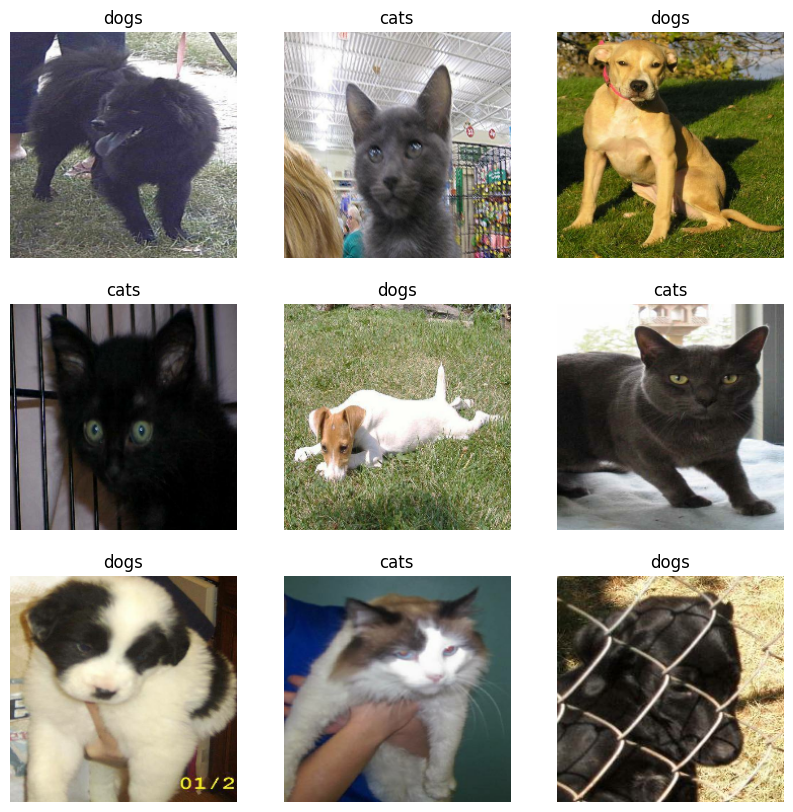

In [18]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# 3.Train model using Backbone VGG16

In [19]:
# define packge
from keras.applications import VGG16
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

In [20]:
baseModel = VGG16(weights='imagenet', include_top=False,\
                                        input_tensor=Input(shape=(224,224,3)))
fcHead = baseModel.output # get output VGG16
fcHead = Flatten()(fcHead) # Flatten

# Add FC
fcHead = Dense(200,activation="relu")(fcHead)
fcHead = Dense(100, activation="relu")(fcHead)
fcHead = Dense(2, activation="softmax")(fcHead) # sotfmax

# build model input baseModel output fcHead
model = Model(inputs=baseModel.input, outputs=fcHead)
for layer in baseModel.layers:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Note:
<h4> Looking</h4>
<ul  >
  <li> loss:  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy">tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)</a> </li>
  <li> metrics:  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy">tf.keras.metrics.SparseCategoricalAccuracy()</a> </li>
</ul>



<h4> Learning more </h4>
<ul>
  <li><h3>Loss: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses"> https://www.tensorflow.org/api_docs/python/tf/keras/losses</a> </h3></li>

  <li><h3>Loss: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/metrics"> https://www.tensorflow.org/api_docs/python/tf/keras/metrics</a> </h3></li>

<ul>

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
# Note:
#  +Loss
#  +metrics
history = model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


219/313 [===================>..........] - ETA: 23s - loss: 0.4206 - sparse_categorical_accuracy: 0.9364

# Save model

In [ ]:
model.save("model.h5")

## Plot Acc

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()